Beats Electronics LLC, also known as Beats by Dr. Dre or simply Beats by Dre, is an American consumer audio products manufacturer headquartered in Culver City, California. In the competitive landscape of audio products, Beats faces numerous rivals, including Sony, Skullcandy, Jabra, and JBL. Understanding customers' needs and emotions is crucial for success in this market. This project will utilize sentiment analysis to assess customer reviews on Amazon for earbuds from Beats, Sony, JBL, Jabra, and Skullcandy.Finally,based on the findings, recommendations for effective marketing campaigns will be proposed.



In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from collections import Counter
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import os
import google.generativeai as genai


In [2]:
Review_df = pd.read_csv('/content/Review_df (1).csv')
Review_df.head(5)

,ID,Title,Author,Rating,Content,Timestamp,Profile ID,Is Verified,Helpful Count,Product Attributes,Product Name
0,R3MQEYLQ6HSUN,"5.0 out of 5 stars Simple to use , good sound ...",MicheleA,5,Honestly ? Much better than expected. Sound is...,"Reviewed in Canada August 4, 2024",AE4QMMKNWWM3JHJJTFNEGMKH7WVQ,True,2,Colour Name: Black,Beats
1,R3JND8CNZWPG7L,5.0 out of 5 stars My honest review,Rachael,5,I’ve had these headphone for over a year so I’...,"Reviewed in Canada March 23, 2024",AF53A7IJCRV66CSGU53OTYXN4KYA,True,49,Colour Name: White,Beats
2,R31P17PCMMIHVF,4.0 out of 5 stars Works well,Amazon Customer,4,"These earbuds are good, first off, pairing the...","Reviewed in Canada August 3, 2024",AFCYGM7KMHYMTJZCXL2FCNKFQU7Q,True,0,Colour Name: Black,Beats
3,R2BMZ6TVOH23TE,5.0 out of 5 stars Love it,Dzodox,5,I bought these for my girlfriend and she likes...,"Reviewed in Canada July 26, 2024",AFK66RWLAKY2WFRZNYGFOGMOHISQ,True,1,NaN,Beats
4,R1XMK3C5SUNQJ0,5.0 out of 5 stars nice one,Arda Gunel,5,It is my first wireless headphone. Yet I canno...,"Reviewed in Canada December 14, 2022",AHET3B3JPFIH2LHC7Q77Z2UNOV7Q,True,28,Colour Name: Black,Beats


In [3]:
Review_df.isnull().sum()

,0
ID,0
Title,0
Author,0
Rating,0
Content,0
Timestamp,0
Profile ID,0
Is Verified,0
Helpful Count,0
Product Attributes,2


In [4]:
Review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  421 non-null    object
 1   Title               421 non-null    object
 2   Author              421 non-null    object
 3   Rating              421 non-null    int64 
 4   Content             421 non-null    object
 5   Timestamp           421 non-null    object
 6   Profile ID          421 non-null    object
 7   Is Verified         421 non-null    bool  
 8   Helpful Count       421 non-null    int64 
 9   Product Attributes  419 non-null    object
 10  Product Name        421 non-null    object
dtypes: bool(1), int64(2), object(8)
memory usage: 33.4+ KB


In [5]:
Review_df['Product Attributes'].describe()

,Product Attributes
count,419
unique,24
top,Colour Name: Black
freq,71


In [6]:
#Handling the missing data by filling the most frequent values on NaN cells
Handle_missing_data=Review_df.fillna('Colour Name: Black', axis=1, inplace= True)

<Figure size 500x400 with 0 Axes>

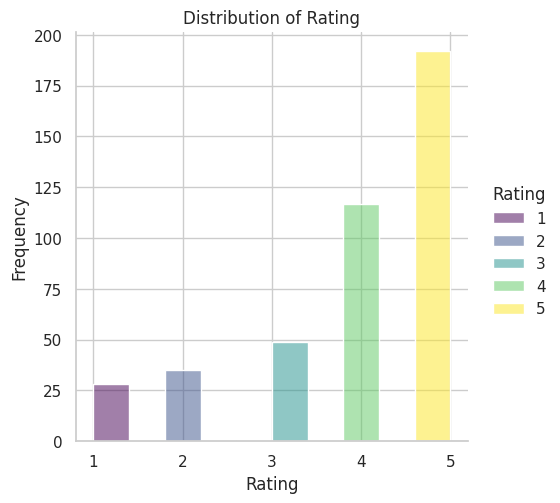

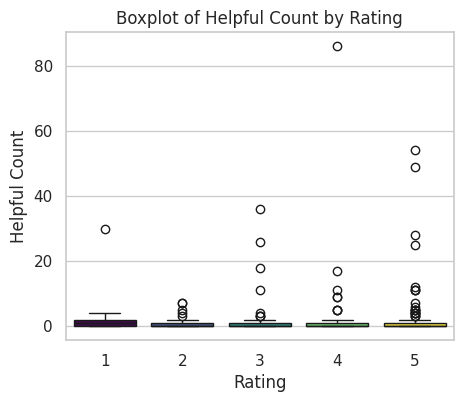

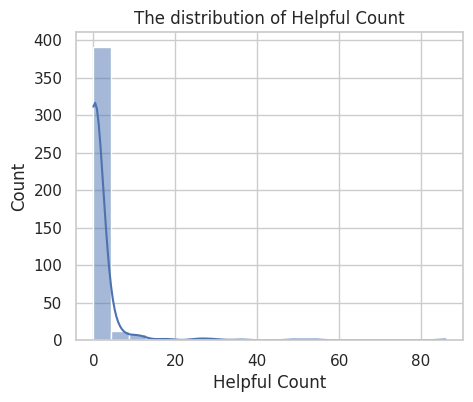

In [7]:
# Visulaize the distribution of rating
sns.set(style="whitegrid")
plt.figure(figsize=(5,4))
sns.displot(x='Rating', data=Review_df, hue='Rating',palette='viridis' )
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()
# Visualize Boxplot of Helpful Count by Rating
plt.figure(figsize=(5,4))
sns.boxplot(x='Rating',y= 'Helpful Count', data=Review_df, hue='Rating', palette='viridis', legend=False )
plt.title('Boxplot of Helpful Count by Rating')
plt.xlabel('Rating')
plt.ylabel('Helpful Count')
plt.show()
# Visuaize the distribution of Helpful Count
plt.figure(figsize=(5,4))
sns.histplot(x='Helpful Count', data=Review_df, bins=20,kde= 'bar')
plt.title('The distribution of Helpful Count')
plt.xlabel('Helpful Count')
plt.show()


**Data Visualization Insights

Rating Distribution:

-The majority of the ratings are concentrated on the higher end (4 and 5 stars), indicating a generally positive sentiment in the reviews.
Helpful Count Distribution:

-Most reviews have a low "Helpful Count," with a significant number of reviews having zero helpful votes. A few outliers have much higher counts, up to 86.
Helpful Count by Rating:

-Reviews with higher ratings (4 and 5 stars) tend to have slightly higher "Helpful Count" values, though there's significant variability across ratings.**bold text**






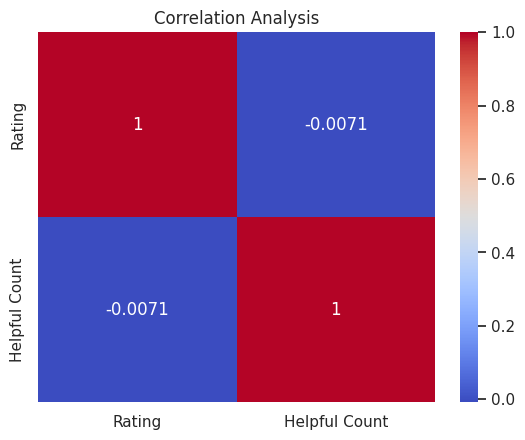

In [8]:
# Correlation Analysis between numeric variables
correlation_matrix = Review_df[['Rating', 'Helpful Count']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Analysis')
plt.show()


The correlation between Rating and Helpful Count is very weak, Rating and Is verified too (close to zero), suggesting that a higher rating does not strongly predict whether a review will receive more helpful votes.

# **Sentiment Analysis using TextBlob**

**Sentiment Polarity:**

Sentiment polarity values range from -1 (most negative) to 1 (most positive), with 0 being neutral.
**Key Interpretations:**
Positive Sentiment (Polarity > 0):

-Reviews with a positive sentiment will have a polarity score greater than 0, indicating the user is expressing favorable opinions about the product.

Neutral Sentiment (Polarity = 0):

-A score close to 0 indicates a neutral sentiment, meaning the review doesn't contain strong positive or negative emotions.

Negative Sentiment (Polarity < 0):

-Negative polarity values indicate dissatisfaction or negative feelings towards the product.

In [9]:
# Create a new column with sentiment index
Review_df['Sentiment Polarity']= Review_df['Content'].apply(lambda x: TextBlob(x).sentiment.polarity)
Review_df[['Sentiment Polarity','Content']].head(10)

,Sentiment Polarity,Content
0,0.136111,Honestly ? Much better than expected. Sound is...
1,0.167079,I’ve had these headphone for over a year so I’...
2,0.142187,"These earbuds are good, first off, pairing the..."
3,0.373333,I bought these for my girlfriend and she likes...
4,0.131667,It is my first wireless headphone. Yet I canno...
5,0.062133,"As far as the sound quality goes, the earbuds ..."
6,0.063855,I think my AirPods Pros broke randomly which p...
7,0.262656,These beauts studio are great little earbuds! ...
8,0.151389,I have never really liked the way buds feel in...
9,0.000000,Les écouteurs ont une excellente qualité de so...


,Sentiment Polarity
Product Name,
Beats,0.258651
Jabra,0.255037
Jbl,0.304009
Skullcandy,0.253679
Sony,0.238037


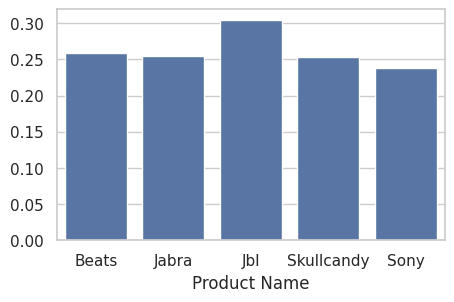

In [24]:

#visualize the Sentiment Polarity of Products
plt.figure(figsize=(5,3))
sns.barplot(x=Review_df.groupby(['Product Name'])['Sentiment Polarity'].mean().index, y=Review_df.groupby(['Product Name'])['Sentiment Polarity'].mean().values)

Review_df.groupby(['Product Name'])['Sentiment Polarity'].mean()

Based On The Sentiment Analysis Process, Jbl(0.3) is in the FIRST place, followed By BEATS(2.58) , JABRA(2.55), SKULLCANDY(0.25) and SONY(0.23)

This step is to know how users complaint about product


In [11]:
# create a sub-table which show product name, content and negative sentiment polarity
Subreview_df = Review_df[Review_df['Sentiment Polarity'] < 0][['Product Name', 'Content', 'Sentiment Polarity']]
Subreview_df.head(2)

,Product Name,Content,Sentiment Polarity
27,Beats,I bought them to replace my skull candy that I...,-0.200000
37,Beats,Same old Beats signature sound thay you either...,-0.066667


In [12]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
def get_top_words(text, n=10):
    words = [word for word in text.lower().split() if word not in stop_words and word.isalpha()]
    word_counts = Counter(words)
    return word_counts.most_common(n)
results = {}
for product_name in Subreview_df['Product Name'].unique():
    product_reviews = Subreview_df[Subreview_df['Product Name'] == product_name]['Content']
    all_words = " ".join(product_reviews).lower()
    top_words = get_top_words(all_words)
    results[product_name] = top_words

print(results)

{'Beats': [('bought', 1), ('replace', 1), ('skull', 1), ('candy', 1), ('lost', 1), ('feel', 1), ('heavy', 1), ('work', 1), ('old', 1), ('beats', 1)], 'Jbl': [('audio', 3), ('worse', 3), ('much', 2), ('feel', 2), ('find', 2), ('use', 2), ('quality', 2), ('static', 2), ('little', 2), ('definitely', 2)], 'Jabra': [('functionality', 3), ('active', 3), ('way', 3), ('ear', 3), ('jabra', 3), ('mycontrols', 2), ('think', 2), ('using', 2), ('button', 2), ('times', 2)], 'Skullcandy': [('charge', 6), ('right', 4), ('go', 2), ('wrong', 2), ('always', 2), ('skullcandy', 2), ('worst', 2), ('recommend', 2), ('one', 2), ('earbud', 2)], 'Sony': [('like', 8), ('earbuds', 8), ('noise', 6), ('button', 6), ('audio', 6), ('feature', 6), ('keeps', 4), ('cutting', 4), ('charged', 4), ('fully', 4)]}


In [14]:
product_name = "Sony"
top_negative_words = ['like','earbuds','noise','button', 'audio','feature', 'keeps', 'cutting', 'charged', 'fully']

# Create a list to store the sentence
negative_sentences = []

# Filter the DataFrame for the specific product
product_reviews = Subreview_df[Subreview_df['Product Name'] == product_name]

# Iterate through the 'Content' column of the filtered DataFrame
for content in product_reviews['Content']:
    # Check if any of the top positive words are present in the content
    if any(word in content.lower() for word in top_negative_words):
        negative_sentences.append(content)

# Print the sentences containing the top positive words for the specific product
for sentence in negative_sentences:
    print(sentence)

Hi sounds ok but the one keeps cutting out. I've charged it fully and it keeps cutting out when playing music. That's no good really. If I don't send back and it's past the time it will probably just stop working all together. Darn. I like them.
I have the WH-1000XM5 and I needed smaller earbuds with the same level of noise cancellation but the WF-C700N was just not it. I couldnt tell the difference when i turned off and on the noise cancellation!!!! Pls recommend me sth with the same level of M5 but small!
I've had problems with earbuds that go deep into ears, thought I'd give these a shot. I'm used to the Bose stayhear tips. Unfortunately these didn't work for me.
The on/off/pause button is terribly located. When pushing the buds into your ears, or adjusting the fit, it's almost impossible not to hit the pause button which takes up like 90% of the exposed surface area.Also, if you happen to fall asleep with the earbuds in, leaning on, or pressing against the on/off button for a few s

In [15]:
# create a sub-table which show product name, content and negative sentiment polarity
Subreview2_df = Review_df[Review_df['Sentiment Polarity'] > 0][['Product Name', 'Content', 'Sentiment Polarity']]
Subreview2_df.head(2)

,Product Name,Content,Sentiment Polarity
0,Beats,Honestly ? Much better than expected. Sound is...,0.136111
1,Beats,I’ve had these headphone for over a year so I’...,0.167079


In [16]:
def get_top_words(text, n=10):
    words = [word for word in text.lower().split() if word not in stop_words and word.isalpha()]
    word_counts = Counter(words)
    return word_counts.most_common(n)
results = {}
for product_name in Subreview2_df['Product Name'].unique():
    product_reviews = Subreview2_df[Subreview2_df['Product Name'] == product_name]['Content']
    all_words = " ".join(product_reviews).lower()
    top_words = get_top_words(all_words)
    results[product_name] = top_words

print(results)

{'Beats': [('noise', 33), ('sound', 29), ('like', 26), ('buds', 25), ('quality', 22), ('beats', 21), ('good', 21), ('ear', 20), ('really', 19), ('earbuds', 18)], 'Jbl': [('sound', 48), ('good', 42), ('noise', 34), ('like', 30), ('great', 28), ('quality', 28), ('ear', 25), ('battery', 21), ('earbuds', 21), ('one', 20)], 'Jabra': [('sound', 77), ('earbuds', 72), ('quality', 51), ('good', 51), ('noise', 49), ('jabra', 49), ('ear', 48), ('elite', 47), ('really', 38), ('like', 37)], 'Skullcandy': [('sound', 30), ('great', 19), ('ear', 19), ('earbuds', 18), ('good', 18), ('headphones', 16), ('quality', 15), ('love', 14), ('one', 14), ('would', 14)], 'Sony': [('sound', 84), ('earbuds', 70), ('noise', 50), ('quality', 47), ('great', 38), ('sony', 34), ('battery', 32), ('case', 29), ('price', 29), ('app', 28)]}


In [17]:
product_name = "Sony"
top_positive_words = ['sound','earbuds','noise','quality','great','sony','battery','case','price','app']

# Create a list to store the sentences
positive_sentences = []

# Filter the DataFrame for the specific product
product_reviews = Subreview2_df[Subreview2_df['Product Name'] == product_name]

# Iterate through the 'Content' column of the filtered DataFrame
for content in product_reviews['Content']:
    # Check if any of the top positive words are present in the content
    if any(word in content.lower() for word in top_positive_words):
        positive_sentences.append(content)

# Print the sentences containing the top positive words for the specific product
for sentence in positive_sentences:
    print(sentence)

the sound is great, you might want to use the app to get them well tuned. once you got them set up to you like they are great. crisp solid sound the anc its ok, not amazing, but overall they are excellent, not too expensive, comfortable .
Pros:Buttons are smooth and tactile, so no accidental taps to the side, however not difficult to press either.Good build quality, solid case, and earbuds felt well made, with no rough edges.Transparency mode is great, felt like I wasn't wearing earbuds with how much sound was being amplified.Neutral:Sound quality is good, but not great, but can be adjusted using the equalizer in the app which is quite thorough. I noticed some roughness in certain songs, which was annoying.Cons:Noise cancelling is not great, with knocking sounds not being blocked at all, and difficulty blocking voices. This is not an issue in a pair of earbuds that are cheaper (Soundcore Liberty 4 NC).Battery life is ridiculous, about 18 hours total with case and earbuds combined. Size

In [31]:
genai.configure(api_key="Your API")

# Create the model
generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 40,
  "max_output_tokens": 8192,
  "response_mime_type": "text/plain",
}

model = genai.GenerativeModel(
  model_name="gemini-1.5-pro-002",
  generation_config=generation_config,
  # safety_settings = Adjust safety settings
  # See https://ai.google.dev/gemini-api/docs/safety-settings
)

chat_session = model.start_chat()
history=[]
response = chat_session.send_message("""write your prompt here""")
print(response.text)

THESE ARE INSIGHTS WHAT I FOUND AFTER SENTIMENT ANALYSIS:

pros of Beats:
* **Sound Quality:**  Many reviewers mention the clear, amazing sound, good bass, and overall enjoyable audio experience, even comparing it favorably to AirPods. Some appreciate the balanced sound signature.
* **Comfort and Fit:** Several users find them comfortable for long periods, even sleeping in them.  Some emphasize how securely they stay in their ears, even during workouts.
* **Ease of Pairing/Connectivity:** The quick and easy pairing, especially with iPhones, is frequently highlighted.
* **Noise Cancellation:** While some find the noise cancellation "decent" or "acceptable" for the price, others praise it as "amazing" and effective for various environments.
* **Battery Life:** The long battery life of both the earbuds and the case receives positive comments.  Fast charging is also mentioned.
* **Physical Buttons:**  Some users prefer the tactile buttons over touch controls, appreciating the click and responsiveness.
* **Size/Design:** The small and compact size of the earbuds and case is seen as a plus, along with their aesthetic appeal.
* **Price:** Many consider them a good value for the features offered, particularly when compared to AirPods.
* **Durability:** One reviewer mentioned that they still worked after being accidentally dropped in liquid.

Cons of Beats:

**Heaviness/Fit:** The earbuds feel heavy in the ears.
* **Inconsistent Volume:**  The volume level changes drastically when connecting to different devices, and is sometimes extremely low, especially with Macs. This is particularly problematic for video/audio calls.

Pros of Jbl:**

* **Good Sound Quality:**  Most reviewers praise the sound, particularly the bass response.  Some compare it favorably to AirPods. Crisp and clear audio is frequently mentioned.
* **Long Battery Life:**  The earbuds themselves hold a charge for a long time, often exceeding expectations and lasting for days of use rather than just hours.  The case battery life, while degrading over time, still offers multiple charges.
* **Comfortable Fit (for some):** Many reviewers find them comfortable, particularly those who dislike in-ear style earbuds.  They stay in place well for many users, even during workouts.
* **Good Value (especially on sale):**  Many reviewers feel these earbuds offer excellent value, especially when purchased at a discounted price.
* **Fast Charging:** The case charges quickly.
* **Useful App:**  The JBL app allows for customization and control of features.
* **Decent Noise Cancelling (for some):** While some find the noise cancellation impressive, particularly for the price, others find it subpar, especially in very noisy environments.  It seems effectiveness varies depending on the individual and their environment

Cons of Jbl:

* **Poor Fit/Loose Feeling:** The earbuds feel loose and require constant adjustment.  The customer suspects their ears might be too large for the provided ear tips.
* **Worse Sound Quality Compared to JBL Tune 230NC:**  Specifically, high notes have crackly static even at lower volumes. Overall audio quality is considered slightly worse than the previous generation.
* **Subpar Ambient Aware:**  A subtle static noise in the background makes the Ambient Aware mode unpleasant.
* **Inferior ANC (Active Noise Cancelling):**  ANC is worse than the 230NC and doesn't work with a single earbud.
* **Lower Maximum Volume:**  The customer feels the earbuds could be louder. (Although they acknowledge this might be due to their hearing.)
* **Overall Decline in Quality:** A general feeling that both audio and the overall feel of the earbuds are worse than the previous model.

Pros of Jabra:

*Secure fit:**  Stay in place even during vigorous activity like jumping, dancing, and running.
* **Long battery life:**  Multiple days of use from a single charge of the case, and a full workday on a single earbud charge.
* **Effective noise cancellation:**  Blocks out noise in loud environments like concerts and restaurants, although some loud noises may still be audible.
* **Great value:**  Especially when purchased on sale.
* **Impressive sound quality:**  Described as "great," "superb," and having "ample amounts of bass."
* **Good hear-through functionality:** Though some find it not as crisp as other models, it allows for awareness of surroundings.
* **Convenient app:** Offers control over settings and customization.
* **Durable:** Withstands sweat, dust, water, and drops.
* **Easy to use:** Some prefer them over newer models.
* **Comfortable:** Can be worn for hours without discomfort, even for sleep.
* **Crystal clear voice/call quality.**
* **Fast charging.**
* **Reliable Bluetooth connectivity:** Though some users have experienced occasional interference and drops.
* **Physical buttons:** Preferred by some over touch controls.

Cons of Jabra:

* **Removal of MyControls:**  Customers miss the ability to customize the button controls, especially during exercise.  The default controls are cumbersome.
* **Stiff Buttons:** The buttons are hard to press, requiring excessive force and pushing the earbuds uncomfortably deep into the ear canal.
* **Lack of Multi-Device Connection:** Switching between devices (like phone and PC) is cumbersome due to the absence of multi-device pairing.
* **Occasional Power-On Issues:**  The earbuds sometimes require manual powering on after removal from the case.
* **Hissing Sound with ANC/HearThrough:** Some users experience a persistent hissing sound in the right earbud when using Active Noise Cancellation (ANC) or HearThrough mode.
* **Poor Fit and Comfort:**  The earbuds don't fit some ears well, leading to discomfort, falling out, and short battery life (4 hours).

Pros of Skullcandy:

 Great battery life (outside the case and overall)
* Nice case design, both interior and exterior.
* Excellent sound quality with good bass.
* Comfortable fit, "stick right to my ear".
* Voice control works well.
* Connects with more than one device without problems.
* Fast recharge.
* App allows for tap settings customization and equalizer adjustments.
* Good for Teams calls.
* Better than Apple AirPods.
* Solid build and sound.
* Clear sound.
* Affordable price for the quality.

Cons of Skullcandy:

* **Poor Bluetooth connection:**  Worst connection experienced among Skullcandy products.
* **Syncing issues:** Difficulty syncing earbuds properly.
* **Charging problems:** One earbud not charging or syncing, right earbud not holding a charge, short battery life (65 minutes even when fully charged), case only charges earbuds when plugged in.
* **Low quality:** Described as "garbage" and the worst earbuds owned.
* **Disappointment:**



Pros of Sony:

* **Great sound quality:**  Many reviewers mention excellent or crisp, solid sound, especially after tuning with the app.  Some even compare it favorably to AirPod Pro 2 and find the sound quality superior for the price.
* **Comfort:** Several reviewers highlight the comfortable fit, even for extended wear (9+ hours).  One reviewer specifically noted these were the most comfortable earbuds they'd tried, better than AirPod Pros, XB700, Beats Studio, and Bose QC.
* **Affordable price:** Especially when on sale, the price is considered a major advantage, offering comparable features to much more expensive models.
* **Long battery life:**  Many users report impressive battery life, lasting several days of moderate use or a full workday and commute on a single charge.
* **Good noise cancellation:** While not "world-class," the noise cancellation is generally considered effective, especially for the price, and works well in environments like buses or planes.
* **Customizability:** The accompanying app allows for EQ adjustments and personalized sound settings, which is highly appreciated.
* **Physical buttons:**  Some reviewers appreciate the physical buttons over touch controls, finding them more reliable and less prone to accidental activation.
* **Ease of use and setup:**  Pairing and setup are described as quick and easy.
* **Aesthetically pleasing:**  The pastel purple color option is mentioned as a positive aspect.
* **Good Transparency/Ambient Sound Mode:** This feature is highlighted for effectively amplifying surrounding sounds, making it feel like the earbuds aren't even in.

Cons of Sony:

* **Intermittent audio cutting out:** One earbud repeatedly cuts out during music playback, even after a full charge.
* **Ineffective noise cancellation:**  The noise cancellation is weak and barely noticeable, not comparable to the WH-1000XM5.
* **Poor earbud fit:**  The earbuds don't fit comfortably for all users, particularly those accustomed to different ear tip styles (like Bose StayHear).
* **Poorly placed button/controls:** The on/off/pause button is too large and easy to accidentally trigger, leading to unintended pauses, voice calls, and FaceTime audio calls.
* **Lack of automatic shutoff:** The earbuds don't automatically turn off when not in use, resulting in poor battery life requiring daily charging.  A 12-hour battery life is desired.
* **Cheap build quality:** The earbuds feel like they are made of cheap plastic.
* **Connectivity issues:**  Inability to connect to two devices simultaneously, despite advertised functionality.
* **Minor noise/static:**  A faint, undesirable noise is present during use.
* **Poor value:** The product's performance doesn't justify its price.




RECOMMENDATION:

SWOT ANALYSIS:

**Strengths:**

* **Sound Quality:**  Beats maintains a reputation for clear, powerful sound with good bass, a key differentiator in the competitive headphone market.  This is particularly strong compared to Skullcandy and potentially even AirPods in some user opinions.
* **Comfort and Fit (for some):**  While fit is subjective, a significant portion of users find Beats comfortable for extended wear, even sleeping in them.  This contrasts with Jabra and Sony where fit issues are more prevalent.
* **Seamless Apple Integration:** The ease of pairing and connectivity with iPhones is a major advantage, leveraging the massive Apple ecosystem.
* **Brand Recognition:** Beats is a well-established and recognizable brand, particularly appealing to younger demographics.
* **Price-to-Performance:** Beats is generally perceived as offering good value for the features provided, especially when compared to Apple AirPods.  This positions them well against competitors like Sony offering similar features.

**Weaknesses:**

* **Inconsistent Volume:**  This is a significant weakness, particularly affecting usability with Macs and during calls. This contrasts with the generally positive sound quality reviews.
* **Heaviness/Fit (for some):**  While comfortable for some, the perceived heaviness can be a deterrent for others, especially compared to lighter options. This is a direct contrast to Jabra's emphasis on secure fit.
* **Noise Cancellation Inconsistencies:**  While some praise the noise cancellation, others find it merely decent, leaving room for improvement compared to competitors like Sony and Jabra who tout stronger ANC.

OPPORTUNITY:

* **Improve Volume Consistency:** Addressing the volume inconsistency issue is crucial and could significantly improve user satisfaction and reviews.
* **Refine Fit and Comfort:** Exploring lighter materials and alternative ear tip designs could broaden appeal and address the fit concerns raised by some users.  This could directly challenge Jabra's strength in secure fit.
* **Enhance Noise Cancellation:** Improving noise cancellation technology could position Beats more competitively against Sony and Jabra, particularly in the premium segment.
* **Expand Product Line:**  Exploring new form factors, such as open-ear designs or headphones targeting specific use cases (e.g., gaming), could expand market reach.
* **Leverage Apple Ecosystem:** Further integrating Beats with Apple services and features (e.g., seamless switching between devices, lossless audio support) could strengthen its value proposition.

**Threats:**

* **Intense Competition:** The headphone market is highly competitive, with established players like Sony, Jabra, and JBL, as well as emerging brands, constantly innovating and offering competitive pricing.
* **Shifting Consumer Preferences:**  Consumer preferences in audio technology are constantly evolving, and Beats must stay ahead of trends in features, design, and sound quality.
* **Negative Reviews Related to Volume and Fit:**  Unresolved issues with volume inconsistency and fit can damage Beats' reputation and hinder sales.
* **Price Sensitivity:** While Beats offers good value, consumers are increasingly price-conscious, and competitive pricing pressure from other brands poses a threat.

## Product Improvement Suggestions:

* **Software Update for Volume Control:**  Prioritize a software update to address the volume inconsistency issue across different devices.
* **Ergonomic Redesign:** Invest in research and development to create lighter and more universally comfortable earbud designs, including offering a wider variety of ear tip sizes and materials.
* **Advanced Noise Cancellation Technology:** Incorporate improved noise cancellation technology in future models to compete with market leaders.

## Marketing Strategies:

* **Highlight Sound Quality and Apple Integration:** Emphasize Beats' strong sound quality and seamless Apple ecosystem integration in marketing campaigns, targeting Apple users.
* **Address Consumer Concerns Directly:**  Publicly acknowledge and address the volume and fit issues through blog posts, social media updates, and product demonstrations, showcasing the improvements made.
* **Targeted Advertising:** Use data-driven advertising to target specific demographics (e.g., athletes, music lovers) with tailored messages highlighting relevant features and benefits.
* **Influencer Marketing:** Partner with influencers and athletes who resonate with the target audience to showcase the improved comfort, sound quality, and noise cancellation.
* **Focus on User-Generated Content:** Encourage user reviews and testimonials to build trust and demonstrate the positive experiences with the improved product.
* **Promotional Offers and Bundles:** Offer attractive promotional bundles with Apple products or subscriptions to enhance the perceived value and drive sales.  This could also tie in with back-to-school promotions or holiday sales.
* **Content Marketing:** Create engaging content (e.g., blog posts, videos) showcasing the technology behind Beats' sound quality, noise cancellation, and comfort features, building credibility and educating consumers.